In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tushare as ts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('msft_daily_df.csv')
df.head()

,Unnamed: 0,_id,Symbol,Date,volume_change,volume_score,bullish,bearish,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0,5ecad5b3e11e78d978b08a5b,MSFT,2020-05-24,-2.97,1766.0,87.02,12.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5ecad5b3e11e78d978b08a5c,MSFT,2020-05-23,-5.50,1820.0,86.85,13.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5ecad5b3e11e78d978b08a5d,MSFT,2020-05-22,-3.60,1926.0,86.90,13.10,183.19,184.46,182.54,183.51,20826900.0,0.00,0.0
3,3,5ecad5b3e11e78d978b08a5e,MSFT,2020-05-21,-3.85,1998.0,88.26,11.74,185.40,186.67,183.29,183.43,29119500.0,0.00,0.0
4,4,5ecad5b3e11e78d978b08a5f,MSFT,2020-05-20,-4.42,2078.0,87.47,12.53,184.81,185.85,183.94,185.66,31261300.0,0.51,0.0


In [3]:
df= df.sort_values(by='Date')
df = df[['bullish','bearish','Date','Open','High','Low','Close','Volume']]
df['bullish'].fillna(method = 'backfill',inplace=True)
df['bearish'].fillna(method = 'backfill',inplace=True)
df.set_index(["Date"], inplace=True)
df.dropna(axis =0, inplace = True)
df.head()

,bullish,bearish,Open,High,Low,Close,Volume
Date,,,,,,,
2020-03-25,56.33,43.67,148.50,153.90,144.04,146.51,75638200.0
2020-03-26,58.73,41.27,147.99,156.22,147.96,155.68,64568100.0
2020-03-27,58.73,41.27,151.33,154.46,148.79,149.28,57042300.0
2020-03-30,63.91,36.09,152.02,160.15,149.59,159.78,63420300.0
2020-03-31,64.52,35.48,158.96,164.32,156.13,157.27,77927200.0


In [4]:
#parameter setting
timesteps = seq_length = 1 
data_dim = 7 
output_dim = 1 

In [5]:
#train_test_split
X = df
y = df.Close
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [6]:
#normalization
scaler = MinMaxScaler()
X_train_new = scaler.fit_transform(X_train)
y_train_new = scaler.fit_transform(y_train.values.reshape(-1, 1))

dataX = []
dataY = []
for i in range(0, len(y_train_new) - seq_length):
    _x = X_train_new[i:i + seq_length]
    _y = y_train_new[i + seq_length]  # Next close price
    dataX.append(_x)
    dataY.append(_y)

x_real = np.vstack(dataX).reshape(-1,seq_length,data_dim)
y_real= np.vstack(dataY).reshape(-1,output_dim)
print(x_real.shape)
print(y_real.shape)
dataX = x_real
dataY = y_real

trainX, trainY = dataX, dataY

(35, 1, 7)
(35, 1)


In [7]:
X_test_new = scaler.transform(X_test)
y_test_new = scaler.transform(y_test.values.reshape(-1, 1))

dataX = []
dataY = []

for i in range(0, len(y_test_new) - seq_length):
    _x = X_test_new[i:i + seq_length]
    _y = y_test_new[i + seq_length]  # Next close price
    dataX.append(_x)
    dataY.append(_y)
    
x_real = np.vstack(dataX).reshape(-1,seq_length,data_dim)
y_real= np.vstack(dataY).reshape(-1,output_dim)
print(x_real.shape)
print(y_real.shape)
dataX = x_real
dataY = y_real

testX, testY = dataX, dataY

(15, 1, 7)
(15, 1)


In [8]:
from keras.layers import Input, Dense, LSTM, Reshape,Dropout
from keras.models import Model
from keras import regularizers


Using TensorFlow backend.


In [28]:
rnn_units = 10
Dense_input = Input(shape=(seq_length, data_dim), name='dense_input') #input

Dense_output_1 = Dense(rnn_units, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='dense1')(Dense_input) 

lstm_input = Reshape(target_shape=(seq_length, rnn_units), name='reshape2')(Dense_output_1) #(None，seq_length, rnn_units）
lstm_output = LSTM(rnn_units, activation='tanh', dropout=1.0, name='lstm')(lstm_input) #LSTM

Dense_input_2 = Reshape(target_shape=(rnn_units,), name='reshape3')(lstm_output) #（None，rnn_units）
Dense_output_2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='dense2')(Dense_input_2) 
#Dense_output_3 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='dense3')(Dense_output_2) 
predictions = Dense(output_dim, activation=None, kernel_regularizer=regularizers.l2(0.01), name='dense4')(Dense_output_2) 

model = Model(inputs=Dense_input, outputs=predictions)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(trainX, trainY, batch_size=256, epochs=100, verbose=2, validation_split=0.1)

model.summary()

Train on 31 samples, validate on 4 samples
Epoch 1/100
 - 2s - loss: 0.8811 - mean_absolute_error: 0.7439 - val_loss: 0.6760 - val_mean_absolute_error: 0.6054
Epoch 2/100
 - 0s - loss: 0.8648 - mean_absolute_error: 0.7338 - val_loss: 0.6654 - val_mean_absolute_error: 0.5968
Epoch 3/100
 - 0s - loss: 0.8491 - mean_absolute_error: 0.7240 - val_loss: 0.6551 - val_mean_absolute_error: 0.5882
Epoch 4/100
 - 0s - loss: 0.8339 - mean_absolute_error: 0.7146 - val_loss: 0.6453 - val_mean_absolute_error: 0.5799
Epoch 5/100
 - 0s - loss: 0.8193 - mean_absolute_error: 0.7055 - val_loss: 0.6356 - val_mean_absolute_error: 0.5717
Epoch 6/100
 - 0s - loss: 0.8051 - mean_absolute_error: 0.6966 - val_loss: 0.6261 - val_mean_absolute_error: 0.5635
Epoch 7/100
 - 0s - loss: 0.7910 - mean_absolute_error: 0.6876 - val_loss: 0.6168 - val_mean_absolute_error: 0.5554
Epoch 8/100
 - 0s - loss: 0.7772 - mean_absolute_error: 0.6786 - val_loss: 0.6077 - val_mean_absolute_error: 0.5474
Epoch 9/100
 - 0s - loss: 0.7

Epoch 71/100
 - 0s - loss: 0.2781 - mean_absolute_error: 0.2597 - val_loss: 0.2782 - val_mean_absolute_error: 0.2689
Epoch 72/100
 - 0s - loss: 0.2759 - mean_absolute_error: 0.2567 - val_loss: 0.2776 - val_mean_absolute_error: 0.2693
Epoch 73/100
 - 0s - loss: 0.2739 - mean_absolute_error: 0.2538 - val_loss: 0.2771 - val_mean_absolute_error: 0.2697
Epoch 74/100
 - 0s - loss: 0.2721 - mean_absolute_error: 0.2510 - val_loss: 0.2766 - val_mean_absolute_error: 0.2701
Epoch 75/100
 - 0s - loss: 0.2704 - mean_absolute_error: 0.2483 - val_loss: 0.2763 - val_mean_absolute_error: 0.2704
Epoch 76/100
 - 0s - loss: 0.2688 - mean_absolute_error: 0.2458 - val_loss: 0.2759 - val_mean_absolute_error: 0.2708
Epoch 77/100
 - 0s - loss: 0.2674 - mean_absolute_error: 0.2433 - val_loss: 0.2757 - val_mean_absolute_error: 0.2711
Epoch 78/100
 - 0s - loss: 0.2661 - mean_absolute_error: 0.2412 - val_loss: 0.2754 - val_mean_absolute_error: 0.2714
Epoch 79/100
 - 0s - loss: 0.2649 - mean_absolute_error: 0.2394 

In [22]:
lstm_input = Input(shape=(seq_length, data_dim), name='lstm_input')
lstm_output = LSTM(128,activation='tanh', dropout=0.5)(lstm_input)#LSTM
Dense_output_1 = Dense(64, activation='relu')(lstm_output)
Dense_output_2 = Dense(16, activation='relu')(Dense_output_1)
predictions = Dense(output_dim, activation='tanh')(Dense_output_2)

model = Model(inputs=lstm_input, outputs=predictions)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(trainX, trainY, batch_size=len(trainX), epochs=300, verbose=2)

model.summary()

Epoch 1/300
 - 1s - loss: 0.5380 - mean_absolute_error: 0.6803
Epoch 2/300
 - 0s - loss: 0.5000 - mean_absolute_error: 0.6508
Epoch 3/300
 - 0s - loss: 0.4776 - mean_absolute_error: 0.6339
Epoch 4/300
 - 0s - loss: 0.4323 - mean_absolute_error: 0.6007
Epoch 5/300
 - 0s - loss: 0.3992 - mean_absolute_error: 0.5728
Epoch 6/300
 - 0s - loss: 0.3846 - mean_absolute_error: 0.5576
Epoch 7/300
 - 0s - loss: 0.3514 - mean_absolute_error: 0.5329
Epoch 8/300
 - 0s - loss: 0.3104 - mean_absolute_error: 0.4986
Epoch 9/300
 - 0s - loss: 0.3204 - mean_absolute_error: 0.4977
Epoch 10/300
 - 0s - loss: 0.2769 - mean_absolute_error: 0.4652
Epoch 11/300
 - 0s - loss: 0.2619 - mean_absolute_error: 0.4517
Epoch 12/300
 - 0s - loss: 0.2419 - mean_absolute_error: 0.4325
Epoch 13/300
 - 0s - loss: 0.2161 - mean_absolute_error: 0.4053
Epoch 14/300
 - 0s - loss: 0.2100 - mean_absolute_error: 0.3907
Epoch 15/300
 - 0s - loss: 0.1890 - mean_absolute_error: 0.3839
Epoch 16/300
 - 0s - loss: 0.1589 - mean_absolute

Epoch 129/300
 - 0s - loss: 0.0725 - mean_absolute_error: 0.2367
Epoch 130/300
 - 0s - loss: 0.0752 - mean_absolute_error: 0.2334
Epoch 131/300
 - 0s - loss: 0.0789 - mean_absolute_error: 0.2404
Epoch 132/300
 - 0s - loss: 0.0773 - mean_absolute_error: 0.2389
Epoch 133/300
 - 0s - loss: 0.0794 - mean_absolute_error: 0.2359
Epoch 134/300
 - 0s - loss: 0.0885 - mean_absolute_error: 0.2523
Epoch 135/300
 - 0s - loss: 0.0823 - mean_absolute_error: 0.2470
Epoch 136/300
 - 0s - loss: 0.0652 - mean_absolute_error: 0.2193
Epoch 137/300
 - 0s - loss: 0.0799 - mean_absolute_error: 0.2411
Epoch 138/300
 - 0s - loss: 0.0759 - mean_absolute_error: 0.2392
Epoch 139/300
 - 0s - loss: 0.0708 - mean_absolute_error: 0.2244
Epoch 140/300
 - 0s - loss: 0.0803 - mean_absolute_error: 0.2469
Epoch 141/300
 - 0s - loss: 0.0811 - mean_absolute_error: 0.2419
Epoch 142/300
 - 0s - loss: 0.0775 - mean_absolute_error: 0.2372
Epoch 143/300
 - 0s - loss: 0.0862 - mean_absolute_error: 0.2517
Epoch 144/300
 - 0s - los

 - 0s - loss: 0.0756 - mean_absolute_error: 0.2354
Epoch 256/300
 - 0s - loss: 0.0758 - mean_absolute_error: 0.2306
Epoch 257/300
 - 0s - loss: 0.0813 - mean_absolute_error: 0.2479
Epoch 258/300
 - 0s - loss: 0.0699 - mean_absolute_error: 0.2276
Epoch 259/300
 - 0s - loss: 0.0751 - mean_absolute_error: 0.2306
Epoch 260/300
 - 0s - loss: 0.0767 - mean_absolute_error: 0.2365
Epoch 261/300
 - 0s - loss: 0.0744 - mean_absolute_error: 0.2296
Epoch 262/300
 - 0s - loss: 0.0766 - mean_absolute_error: 0.2366
Epoch 263/300
 - 0s - loss: 0.0711 - mean_absolute_error: 0.2255
Epoch 264/300
 - 0s - loss: 0.0725 - mean_absolute_error: 0.2336
Epoch 265/300
 - 0s - loss: 0.0797 - mean_absolute_error: 0.2461
Epoch 266/300
 - 0s - loss: 0.0758 - mean_absolute_error: 0.2373
Epoch 267/300
 - 0s - loss: 0.0736 - mean_absolute_error: 0.2326
Epoch 268/300
 - 0s - loss: 0.0749 - mean_absolute_error: 0.2399
Epoch 269/300
 - 0s - loss: 0.0774 - mean_absolute_error: 0.2404
Epoch 270/300
 - 0s - loss: 0.0729 - me

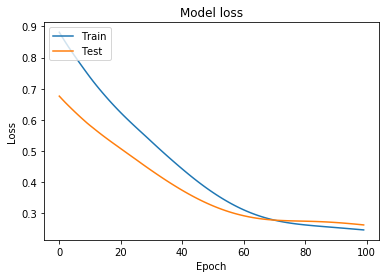

In [29]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


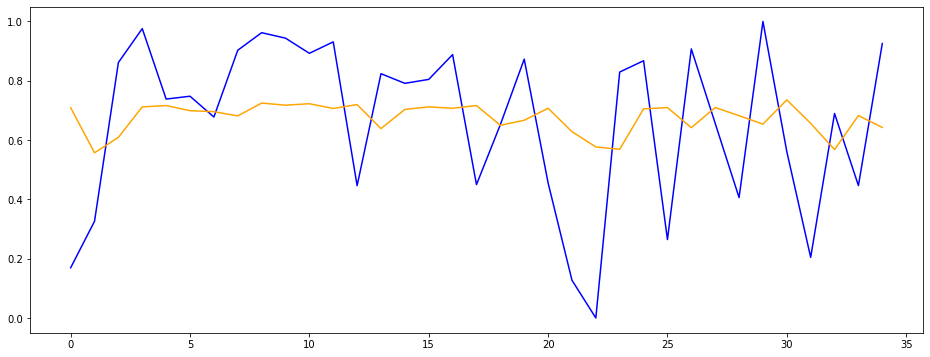

In [30]:
trainPredict = model.predict(trainX) 
trainPredict2 = trainPredict * scaler.data_range_[0] + scaler.data_min_[0] 
trainY2 = trainY * scaler.data_range_[0] + scaler.data_min_[0] 

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(trainY,color='blue')
ax.plot(trainPredict,color='orange')


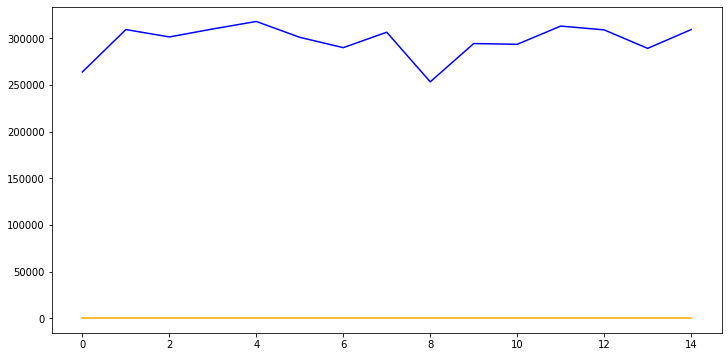

In [31]:
Predict = model.predict(testX)
testPredict = scaler.inverse_transform(Predict)
testY = scaler.inverse_transform(testY)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(testY,color='blue')
ax.plot(testPredict,color='orange')